## Petrological estimate of beta

Revise calculation of beta in the following way:
* Calculate beta_min, using density, Mg#, alpha, k per mineral
* Calculate average beta for solid part

The calculations for liquid phase remain the same. We have 3 experiments again:
1. Isobaric conditions
2. Isothermal conditions
3. Isentropic conditions

## pMELTS calculations

The compositional effect on density only takes place during melting, so we impose a melting degree between 0-30%.

### Import modules and set pMELTS version:

In [1]:
from thermoengine import equilibrate
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import pickle
%matplotlib inline

rc('font',**{'family':'serif','serif':['Times new roman']})
rc('text', usetex=True)

# MELTS version - pMELTS
melts  = equilibrate.MELTSmodel(version="5.6.1")

/opt/conda/lib/python3.9/site-packages/thermoengine/calibrate.py:378: DeprecationWarning: invalid escape sequence \*
  [re.match(base+'[\*0-9]*', iname) is not None
/opt/conda/lib/python3.9/site-packages/thermoengine/calibrate.py:382: DeprecationWarning: invalid escape sequence \*
  [re.match(base+'\*', iname) is not None
/opt/conda/lib/python3.9/site-packages/thermoengine/equilibrate.py:4014: DeprecationWarning: invalid escape sequence \*
  """Sets the bulk composition of the system


In [2]:
# create empty class for each of the melting curves
class EmptyStruct:
    pass

def create_pmelts_object(bulk_comp):
    melts  = equilibrate.MELTSmodel(version="5.6.1")
    
    if (bulk_comp == 'MM3'):
        melts.set_bulk_composition({'SiO2':45.47, 'TiO2':0.11, 'Al2O3':4.0, 'Fe2O3':0.68,'Cr2O3':0.68, 
                                  'FeO': 6.61, 'MnO':0.0, 'MgO':38.53, 'NiO':0.0,'CoO':0.0,
                                  'CaO': 3.59, 'Na2O':0.31, 'K2O':0.0, 'P2O5':0.0, 'H2O':0.0})
    if (bulk_comp == 'mBas'):
        melts.set_bulk_composition({'SiO2':45.26, 'TiO2':0.19, 'Al2O3':3.88,'Fe2O3':0.40,'Cr2O3':0.41, 
                                   'FeO':7.81, 'MnO':0.0, 'MgO':37.85, 'NiO':0.0, 'CoO':0.0,
                                   'CaO':3.57, 'Na2O':0.30, 'K2O':0.01, 'P2O5':0.0, 'H2O':0.0})
    if (bulk_comp == 'KR4003'):
        melts.set_bulk_composition({'SiO2':44.9, 'TiO2':0.16, 'Al2O3':4.26,'Fe2O3':0.0,'Cr2O3':0.41, 
                                   'FeO':8.02, 'MnO':0.13, 'MgO':37.3, 'NiO':0.24, 'CoO':0.0,
                                   'CaO':3.45, 'Na2O':0.22, 'K2O':0.09, 'P2O5':0.0, 'H2O':0.0}) # requires deep melting
    
    b = melts.get_phase_inclusion_status()
    melts.set_phase_inclusion_status({'Actinolite':False, 'Aegirine':False, \
                                  'Aenigmatite':False, 'Akermanite':False, 'Andalusite':False, \
                                  'Anthophyllite':False, 'Apatite':False, 'Biotite':False, 'Chromite':False, \
                                  'Coesite':False, 'Corundum':False, 'Cristobalite':False, 'Cummingtonite':False, \
                                  'Fayalite':False, 'Forsterite':False, 'Gehlenite':False, 'Hematite':False, \
                                  'Hornblende':False, 'Ilmenite':False, 'Ilmenite ss':False, 'Kalsilite':False, \
                                  'Kalsilite ss':False, 'Kyanite':False, 'Leucite':False, 'Lime':False, \
                                  'Liquid Alloy':False, 'Magnetite':False, 'Melilite':False, 'Muscovite':False, \
                                  'Nepheline':False, 'Nepheline ss':False, 'OrthoOxide':False, 'Panunzite':False, \
                                  'Periclase':False, 'Perovskite':False, 'Phlogopite':False, 'Quartz':False, \
                                  'Rutile':False, 'Sanidine':False, 'Sillimanite':False, 'Solid Alloy':False, \
                                  'Sphene':False, 'Tridymite':False, 'Whitlockite':False})

    # Save phases included:
    Phases_all = []
    a = melts.get_phase_inclusion_status()
    for phase in b.keys():
        if a[phase] == True:
            #print ("{0:<15s} Before: {1:<5s} After: {2:<5s}".format(phase, repr(b[phase]), repr(a[phase])))
            Phases_all.append(phase)

    return melts, Phases_all

def get_wt_frac(melts,root,Phases_solid):
    n = len(Phases_solid)
    x = np.zeros(n) # wt frac
    xs = 0.0
    for i in range (0, n):
        x[i]   = melts.get_property_of_phase(root, Phases_solid[i], property_name='Mass')
        xs = xs + x[i]
    for i in range (0, n):
        x[i]   = x[i]/xs
    return x

# liquid properties
def get_liquid_fraction(melts,root):
    phase = 'Liquid'
    phi = melts.get_property_of_phase(root, phase, property_name='Mass')/melts.get_property_of_phase(root, 'System', property_name='Mass')
    return phi

def get_liquid_density(melts,root):
    rho = 0.0
    phase = 'Liquid'
    phi = get_liquid_fraction(melts,root)
    if (phi>0.0):
        rho = melts.get_property_of_phase(root, phase, property_name='Density')
    return rho

def get_liquid_alpha(melts,root):
    alpha = 0.0
    phase = 'Liquid'
    phi = get_liquid_fraction(melts,root)
    if (phi>0.0):
        alpha = melts.get_property_of_phase(root, phase, property_name='Alpha')
    return alpha

def get_liquid_compressibility(melts,root):
    k = 0.0
    phase = 'Liquid'
    phi = get_liquid_fraction(melts,root)
    if (phi>0.0):
        k = melts.get_property_of_phase(root, phase, property_name='Beta') # pmelts returns k in 1/bar
    return k/0.1 # in 1/MPa

def get_liquid_Mg_number(melts,root):
    phase = 'Liquid'
    M_FeO = 72 # molecular mass
    M_MgO = 40
    Mgf   = 0.0 
    phi = get_liquid_fraction(melts,root)
    if (phi>0.0):
        oxide = melts.get_composition_of_phase(root, phase_name=phase, mode='oxide_wt')
        FeO = oxide["FeO"]
        MgO = oxide["MgO"]
        xFe = FeO/M_FeO
        xMg = MgO/M_MgO
        Mgf = xMg/(xMg+xFe)
    return Mgf

# mineral properties
def get_mineral_Mg_number(melts,root,Phase):    
    M_FeO  = 72 # molecular mass
    M_MgO  = 40
    Mg     = 0.0 
    oxide = melts.get_composition_of_phase(root, phase_name=Phase, mode='oxide_wt')
    if (oxide):
        FeO_s = oxide["FeO"]
        MgO_s = oxide["MgO"]
        xFe = FeO_s/M_FeO
        xMg = MgO_s/M_MgO
        Mg = xMg/(xMg+xFe)       
    return Mg

def get_bulk_property(n,x,a):
    # a = sum(xi*ai)
    a_bulk = 0.0
    for i in range (0, n):
        if (x[i]>0.0):
            a_bulk = a_bulk + x[i]*a[i]
    return a_bulk

def get_bulk_density(n,x,rho):
    rho_bulk_inv = 0.0
    for i in range (0, n):
        if (x[i]>0.0):
            rho_bulk_inv = rho_bulk_inv + x[i]/rho[i]
    return 1.0/rho_bulk_inv

def get_density_Mg_liquid_solid(melts,root,T,P,Phases_all):
    # get solid phases
    Phases_solid = Phases_all.copy()
    Phases_solid.remove('Liquid')
    
    sol=EmptyStruct()
    sol.phases_solid= Phases_solid
    sol.n      = len(Phases_solid)
    sol.rho   = np.zeros(sol.n)
    sol.Mg    = np.zeros(sol.n)
    sol.alpha = np.zeros(sol.n)
    sol.beta  = np.zeros(sol.n)
    sol.k     = np.zeros(sol.n)
    
    # calculate liquid properties
    phi    = get_liquid_fraction(melts,root)
    rhof   = get_liquid_density(melts,root)
    Mgf    = get_liquid_Mg_number(melts,root)
    alphaf = get_liquid_alpha(melts,root)
    kf     = get_liquid_compressibility(melts,root)
    
    # calculate mineral properties
    sol.x = get_wt_frac(melts,root,Phases_solid)
    for i in range (0, sol.n):
        sol.rho[i]   = melts.get_property_of_phase(root, Phases_solid[i], property_name='Density')
        sol.alpha[i] = melts.get_property_of_phase(root, Phases_solid[i], property_name='Alpha')
        sol.k[i]     = melts.get_property_of_phase(root, Phases_solid[i], property_name='Beta')/0.1 # pmelts returns k in 1/bar, transform in 1/MPa
        sol.Mg[i]    = get_mineral_Mg_number(melts,root,Phases_solid[i])
    return phi, rhof, Mgf, alphaf, kf, sol

# beta
def calculate_betaP(rho0,rho1,alpha,DT,DC):
    if (abs(rho0*DC)>1e-10):
        beta = (rho0*(1.0-alpha*DT)-rho1)/(rho0*DC)
    else:
        beta = 0.0
    return beta

def calculate_betaT(rho0,rho1,k,DP,DC):
    if (abs(rho0*DC)>1e-10):
        beta = (rho0*(1.0+k*DP)-rho1)/(rho0*DC)
    else:
        beta = 0.0
    return beta

def calculate_betaS(rho0,rho1,k,alpha,DP,DT,DC):
    if (abs(rho0*DC)>1e-10):
        beta = (rho0*(1.0+k*DP-alpha*DT)-rho1)/(rho0*DC)
    else:
        beta = 0.0
    return beta

### 1. Isobaric conditions (P=ct)

In [3]:
def run_isobaric_melting_mineral(bulk_comp,Tstart,Tfinal,Pstart):
    sim=EmptyStruct()
    sim.bulk_comp = bulk_comp
    melts, Phases_all = create_pmelts_object(sim.bulk_comp)
    
    Phases_solid = Phases_all.copy()
    Phases_solid.remove('Liquid')
    
    p_increment = 0.0
    t_increment = 1.0
    nsteps = int((Tfinal-Tstart)/t_increment)

    sim.p   = np.zeros(nsteps)
    sim.t   = np.zeros(nsteps)
    sim.phi = np.zeros(nsteps)
    sim.rhof= np.zeros(nsteps)
    sim.rhos= np.zeros(nsteps)
    sim.Mgf = np.zeros(nsteps)
    sim.Mgs = np.zeros(nsteps)
    sim.alphaf= np.zeros(nsteps)
    sim.alphas= np.zeros(nsteps)
    sim.kf    = np.zeros(nsteps)
    sim.ks    = np.zeros(nsteps)
    sim.betaf = np.zeros(nsteps-1)
    sim.betas = np.zeros(nsteps-1)
    sim.phases= Phases_all

    sol = [EmptyStruct() for i in range(nsteps)]
    sim.sol = sol
    
    sim.p[0] = Pstart
    sim.t[0] = Tstart

    for i in range (1,nsteps):
        sim.p[i] = sim.p[i-1]+p_increment
        sim.t[i] = sim.t[i-1]+t_increment

    for i in range (0,nsteps):
        if (i==0):
            output = melts.equilibrate_tp(sim.t[i],sim.p[i], initialize=True)
        else:
            output = melts.equilibrate_tp(sim.t[i],sim.p[i])
        (status, t, p, xmlout) = output[0]
        
        # get properties
        sim.sol[i]   = EmptyStruct()
        sim.phi[i], sim.rhof[i], sim.Mgf[i], sim.alphaf[i], sim.kf[i], sim.sol[i] = get_density_Mg_liquid_solid(melts,xmlout,sim.t[i],sim.p[i],Phases_all)
        
        # bulk solid phase
        sim.rhos[i]   = get_bulk_density(sim.sol[i].n,sim.sol[i].x,sim.sol[i].rho)
        sim.alphas[i] = get_bulk_property(sim.sol[i].n,sim.sol[i].x,sim.sol[i].alpha)
        sim.ks[i]     = get_bulk_property(sim.sol[i].n,sim.sol[i].x,sim.sol[i].k)
        sim.Mgs[i]    = get_bulk_property(sim.sol[i].n,sim.sol[i].x,sim.sol[i].Mg)
            
        if (i>0):          
            DT  = sim.t[i]-sim.t[i-1]
            DCF = sim.Mgf[i]-sim.Mgf[i-1]
            sim.betaf[i-1] = calculate_betaP(sim.rhof[i-1],sim.rhof[i],sim.alphaf[i],DT,DCF)
            
            # mineral phase
            for im in range (0, sim.sol[i].n):
                if (sim.sol[i].x[im]>0.0):
                    rho0 = sim.sol[i-1].rho[im]
                    rho  = sim.sol[i].rho[im]
                    alpha= sim.sol[i].alpha[im]
                    DCS  = sim.sol[i].Mg[im]-sim.sol[i-1].Mg[im]
                    sim.sol[i].beta[im] = calculate_betaP(rho0,rho,alpha,DT,DCS)
            sim.betas[i-1] = get_bulk_property(sim.sol[i].n,sim.sol[i].x,sim.sol[i].beta)
    return sim

# simulations - assume 1deg increment
# sim0 = run_isobaric_melting_mineral('MM3',1240,1325,500) # phi [0.05583931 - 0.30363128] - calculations are not reliable
sim1 = run_isobaric_melting_mineral('MM3',1250,1420,1000) # phi [0.00455226 - 0.30010121]
sim2 = run_isobaric_melting_mineral('MM3',1350,1490,1500) # phi [0.00375698 - 0.29942145]
sim3 = run_isobaric_melting_mineral('MM3',1420,1540,2000) # phi [0.00109972 - 0.2950253]

# save pickle data
fname_pickle = 'sim_1_isobaric_v2.pickle'
with open(fname_pickle, 'wb') as fh:
    pickle.dump(sim1,fh)
    pickle.dump(sim2,fh)
    pickle.dump(sim3,fh)

# print(sim3.phi)

## Plots

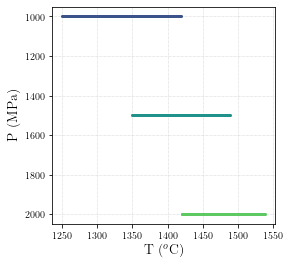

In [4]:
fontsize = 14
linewidth = 2
markersize = 2

colors = plt.cm.viridis(np.linspace(0,1,5))

# PT plot
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1,1,1)
plt.grid(linestyle=':', linewidth=0.5)
# plt.plot(sim0.t, sim0.p, 'o', markersize=markersize, color=colors[0], label='0.5GPa MM3')
plt.plot(sim1.t, sim1.p, 'o', markersize=markersize, color=colors[1], label='1.0GPa MM3')
plt.plot(sim2.t, sim2.p, 'o', markersize=markersize, color=colors[2], label='1.5GPa MM3')
plt.plot(sim3.t, sim3.p, 'o', markersize=markersize, color=colors[3], label='2.0GPa MM3')
plt.xlabel(r'T ($^o$C)', fontsize=fontsize)
plt.ylabel(r'P (MPa)', fontsize=fontsize)
plt.gca().invert_yaxis()
# plt.legend(fontsize='small')
plt.show()

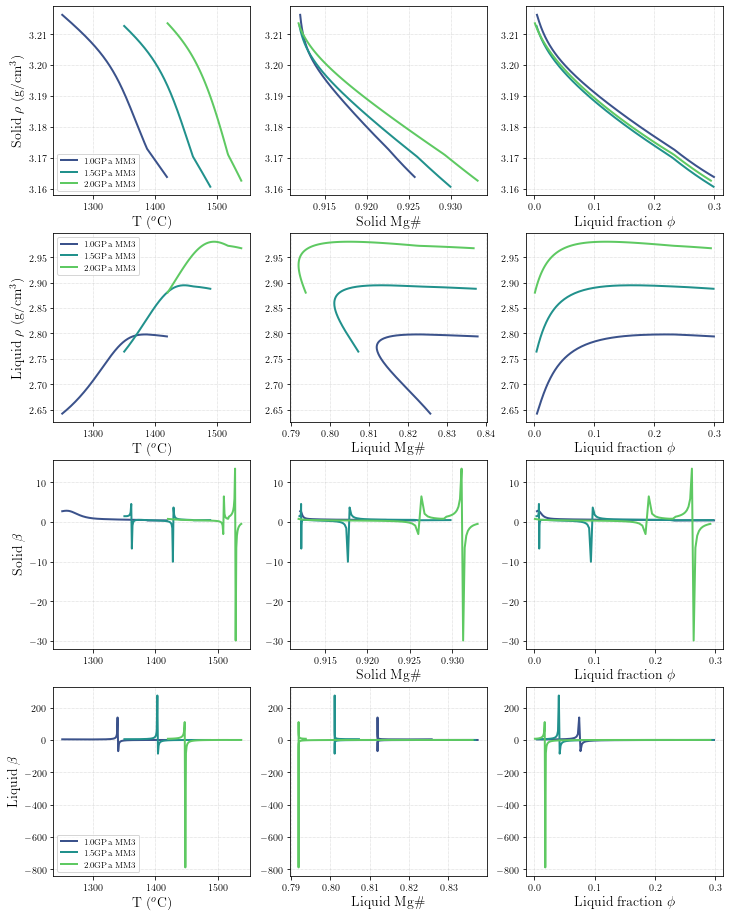

In [5]:
# density vs T, Mg#, phi 

# ind_sim0  = np.where(sim0.phi>0.0)
ind_sim1  = np.where(sim1.phi>0.0)
ind_sim2  = np.where(sim2.phi>0.0)
ind_sim3  = np.where(sim3.phi>0.0)

# Figure 1 - P=2000 MPa
fig = plt.figure(figsize=(12,16))
ax = plt.subplot(4,3,1)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
# plt.plot(sim0.t, sim0.rhos, linestyle='-', linewidth=linewidth, color=colors[0], label='0.5GPa MM3')
plt.plot(sim1.t, sim1.rhos, linestyle='-', linewidth=linewidth, color=colors[1], label='1.0GPa MM3')
plt.plot(sim2.t, sim2.rhos, linestyle='-', linewidth=linewidth, color=colors[2], label='1.5GPa MM3')
plt.plot(sim3.t, sim3.rhos, linestyle='-', linewidth=linewidth, color=colors[3], label='2.0GPa MM3')
plt.xlabel(r'T ($^o$C)', fontsize=fontsize)
plt.ylabel(r'Solid $\rho$ (g/cm$^3$)', fontsize=fontsize)
plt.legend(fontsize='small')

ax = plt.subplot(4,3,2)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
# plt.plot(sim0.Mgs, sim0.rhos, linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.Mgs, sim1.rhos, linestyle='-', linewidth=linewidth, color=colors[1])
plt.plot(sim2.Mgs, sim2.rhos, linestyle='-', linewidth=linewidth, color=colors[2])
plt.plot(sim3.Mgs, sim3.rhos, linestyle='-', linewidth=linewidth, color=colors[3])
plt.xlabel(r'Solid Mg\#', fontsize=fontsize)

ax = plt.subplot(4,3,3)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
# plt.plot(sim0.phi, sim0.rhos, linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.phi, sim1.rhos, linestyle='-', linewidth=linewidth, color=colors[1])
plt.plot(sim2.phi, sim2.rhos, linestyle='-', linewidth=linewidth, color=colors[2])
plt.plot(sim3.phi, sim3.rhos, linestyle='-', linewidth=linewidth, color=colors[3])
plt.xlabel(r'Liquid fraction $\phi$', fontsize=fontsize)

ax = plt.subplot(4,3,4)
plt.grid(linestyle=':', linewidth=0.5)
# plt.plot(sim0.t[ind_sim0[0]], sim0.rhof[ind_sim0[0]], linestyle='-', linewidth=linewidth, color=colors[0], label='0.5GPa MM3')
plt.plot(sim1.t[ind_sim1[0]], sim1.rhof[ind_sim1[0]], linestyle='-', linewidth=linewidth, color=colors[1], label='1.0GPa MM3')
plt.plot(sim2.t[ind_sim2[0]], sim2.rhof[ind_sim2[0]], linestyle='-', linewidth=linewidth, color=colors[2], label='1.5GPa MM3')
plt.plot(sim3.t[ind_sim3[0]], sim3.rhof[ind_sim3[0]], linestyle='-', linewidth=linewidth, color=colors[3], label='2.0GPa MM3')
plt.xlabel(r'T ($^o$C)', fontsize=fontsize)
plt.ylabel(r'Liquid $\rho$ (g/cm$^3$)', fontsize=fontsize)
plt.legend(fontsize='small')

ax = plt.subplot(4,3,5)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
# plt.plot(sim0.Mgf[ind_sim0[0]], sim0.rhof[ind_sim0[0]], linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.Mgf[ind_sim1[0]], sim1.rhof[ind_sim1[0]], linestyle='-', linewidth=linewidth, color=colors[1])
plt.plot(sim2.Mgf[ind_sim2[0]], sim2.rhof[ind_sim2[0]], linestyle='-', linewidth=linewidth, color=colors[2])
plt.plot(sim3.Mgf[ind_sim3[0]], sim3.rhof[ind_sim3[0]], linestyle='-', linewidth=linewidth, color=colors[3])
plt.xlabel(r'Liquid Mg\#', fontsize=fontsize)

ax = plt.subplot(4,3,6)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
# plt.plot(sim0.phi[ind_sim0[0]], sim0.rhof[ind_sim0[0]], linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.phi[ind_sim1[0]], sim1.rhof[ind_sim1[0]], linestyle='-', linewidth=linewidth, color=colors[1])
plt.plot(sim2.phi[ind_sim2[0]], sim2.rhof[ind_sim2[0]], linestyle='-', linewidth=linewidth, color=colors[2])
plt.plot(sim3.phi[ind_sim3[0]], sim3.rhof[ind_sim3[0]], linestyle='-', linewidth=linewidth, color=colors[3])
plt.xlabel(r'Liquid fraction $\phi$', fontsize=fontsize)

ax = plt.subplot(4,3,7)
plt.grid(linestyle=':', linewidth=0.5)
# plt.plot(sim0.t[:-1], sim0.betas, linestyle='-', linewidth=linewidth, color=colors[0], label='0.5GPa MM3')
plt.plot(sim1.t[:-1], sim1.betas, linestyle='-', linewidth=linewidth, color=colors[1], label='1.0GPa MM3')
plt.plot(sim2.t[:-1], sim2.betas, linestyle='-', linewidth=linewidth, color=colors[2], label='1.5GPa MM3')
plt.plot(sim3.t[:-1], sim3.betas, linestyle='-', linewidth=linewidth, color=colors[3], label='2.0GPa MM3')
# plt.xlabel(r'T ($^o$C)', fontsize=fontsize)
plt.ylabel(r'Solid $\beta$', fontsize=fontsize)
# plt.legend(fontsize='small')

ax = plt.subplot(4,3,8)
plt.grid(linestyle=':', linewidth=0.5)
# plt.plot(sim0.Mgs[:-1], sim0.betas, linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.Mgs[:-1], sim1.betas, linestyle='-', linewidth=linewidth, color=colors[1])
plt.plot(sim2.Mgs[:-1], sim2.betas, linestyle='-', linewidth=linewidth, color=colors[2])
plt.plot(sim3.Mgs[:-1], sim3.betas, linestyle='-', linewidth=linewidth, color=colors[3])
plt.xlabel(r'Solid Mg\#', fontsize=fontsize)

ax = plt.subplot(4,3,9)
plt.grid(linestyle=':', linewidth=0.5)
# plt.plot(sim0.phi[:-1], sim0.betas, linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.phi[:-1], sim1.betas, linestyle='-', linewidth=linewidth, color=colors[1])
plt.plot(sim2.phi[:-1], sim2.betas, linestyle='-', linewidth=linewidth, color=colors[2])
plt.plot(sim3.phi[:-1], sim3.betas, linestyle='-', linewidth=linewidth, color=colors[3])
plt.xlabel(r'Liquid fraction $\phi$', fontsize=fontsize)

ax = plt.subplot(4,3,10)
plt.grid(linestyle=':', linewidth=0.5)
# plt.plot(sim0.t[ind_sim0[0][:-1]], sim0.betaf[ind_sim0[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[0], label='0.5GPa MM3')
plt.plot(sim1.t[ind_sim1[0][:-1]], sim1.betaf[ind_sim1[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[1], label='1.0GPa MM3')
plt.plot(sim2.t[ind_sim2[0][:-1]], sim2.betaf[ind_sim2[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[2], label='1.5GPa MM3')
plt.plot(sim3.t[ind_sim3[0][:-1]], sim3.betaf[ind_sim3[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[3], label='2.0GPa MM3')
plt.xlabel(r'T ($^o$C)', fontsize=fontsize)
plt.ylabel(r'Liquid $\beta$', fontsize=fontsize)
plt.legend(fontsize='small')

ax = plt.subplot(4,3,11)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
# plt.plot(sim0.Mgf[ind_sim0[0][:-1]], sim0.betaf[ind_sim0[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.Mgf[ind_sim1[0][:-1]], sim1.betaf[ind_sim1[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[1])
plt.plot(sim2.Mgf[ind_sim2[0][:-1]], sim2.betaf[ind_sim2[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[2])
plt.plot(sim3.Mgf[ind_sim3[0][:-1]], sim3.betaf[ind_sim3[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[3])
plt.xlabel(r'Liquid Mg\#', fontsize=fontsize)

ax = plt.subplot(4,3,12)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
# plt.plot(sim0.phi[ind_sim0[0][:-1]], sim0.betaf[ind_sim0[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.phi[ind_sim1[0][:-1]], sim1.betaf[ind_sim1[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[1])
plt.plot(sim2.phi[ind_sim2[0][:-1]], sim2.betaf[ind_sim2[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[2])
plt.plot(sim3.phi[ind_sim3[0][:-1]], sim3.betaf[ind_sim3[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[3])
plt.xlabel(r'Liquid fraction $\phi$', fontsize=fontsize)

# plt.savefig('density_change_isobaric_v2.pdf')
plt.show()

In [6]:
# Average betaP
print('Average betaP (liquid,solid):')
# print('0.5GPa    : ',np.average(sim0.betaf[ind_sim0[0][:-1]]),np.average(sim0.betas[ind_sim0[0][:-1]]))
print('1.0GPa    : ',np.average(sim1.betaf[ind_sim1[0][:-1]]),np.average(sim1.betas[ind_sim1[0][:-1]]))
print('1.5GPa    : ',np.average(sim2.betaf[ind_sim2[0][:-1]]),np.average(sim2.betas[ind_sim2[0][:-1]]))
print('2.0GPa    : ',np.average(sim3.betaf[ind_sim3[0][:-1]]),np.average(sim3.betas[ind_sim3[0][:-1]]))

Average betaP (liquid,solid):
1.0GPa    :  2.2072881302966216 0.9961231655284728
1.5GPa    :  3.30503470501421 0.4688197083747899
2.0GPa    :  -4.917060330763387 0.3500675979684432


### 2. Isothermal conditions (T=ct)

In [7]:
def run_isothermal_melting_mineral(bulk_comp,Pstart,Pfinal,Tstart):
    sim=EmptyStruct()
    sim.bulk_comp = bulk_comp
    melts, Phases_all = create_pmelts_object(sim.bulk_comp)
    
    p_increment = -10.0
    t_increment = 0.0
    nsteps = int((Pfinal-Pstart)/p_increment)

    sim.p   = np.zeros(nsteps)
    sim.t   = np.zeros(nsteps)
    sim.phi = np.zeros(nsteps)
    sim.rhof= np.zeros(nsteps)
    sim.rhos= np.zeros(nsteps)
    sim.Mgf = np.zeros(nsteps)
    sim.Mgs = np.zeros(nsteps)
    sim.alphaf= np.zeros(nsteps)
    sim.alphas= np.zeros(nsteps)
    sim.kf    = np.zeros(nsteps)
    sim.ks    = np.zeros(nsteps)
    sim.betaf = np.zeros(nsteps-1)
    sim.betas = np.zeros(nsteps-1)
    sim.phases= Phases_all
    
    sol = [EmptyStruct() for i in range(nsteps)]
    sim.sol = sol

    sim.p[0] = Pstart
    sim.t[0] = Tstart

    for i in range (1,nsteps):
        sim.p[i] = sim.p[i-1]+p_increment
        sim.t[i] = sim.t[i-1]+t_increment

    for i in range (0,nsteps):
        if (i==0):
            output = melts.equilibrate_tp(sim.t[i],sim.p[i], initialize=True)
        else:
            output = melts.equilibrate_tp(sim.t[i],sim.p[i])
        (status, t, p, xmlout) = output[0]
        
        # get properties
        sim.sol[i]   = EmptyStruct()
        sim.phi[i], sim.rhof[i], sim.Mgf[i], sim.alphaf[i], sim.kf[i], sim.sol[i] = get_density_Mg_liquid_solid(melts,xmlout,sim.t[i],sim.p[i],Phases_all)
        
        # bulk solid phase
        sim.rhos[i]   = get_bulk_density(sim.sol[i].n,sim.sol[i].x,sim.sol[i].rho)
        sim.alphas[i] = get_bulk_property(sim.sol[i].n,sim.sol[i].x,sim.sol[i].alpha)
        sim.ks[i]     = get_bulk_property(sim.sol[i].n,sim.sol[i].x,sim.sol[i].k)
        sim.Mgs[i]    = get_bulk_property(sim.sol[i].n,sim.sol[i].x,sim.sol[i].Mg)
        
        if (i>0):
            DP  = sim.p[i]-sim.p[i-1] # MPa
            DCF = sim.Mgf[i]-sim.Mgf[i-1]
            sim.betaf[i-1] = calculate_betaT(sim.rhof[i-1],sim.rhof[i],sim.kf[i],DP,DCF)
            
            # mineral phase
            for im in range (0, sim.sol[i].n):
                if (sim.sol[i].x[im]>0.0):
                    rho0 = sim.sol[i-1].rho[im]
                    rho  = sim.sol[i].rho[im]
                    k    = sim.sol[i].k[im]
                    DCS  = sim.sol[i].Mg[im]-sim.sol[i-1].Mg[im]
                    sim.sol[i].beta[im] = calculate_betaT(rho0,rho,k,DP,DCS)
            sim.betas[i-1] = get_bulk_property(sim.sol[i].n,sim.sol[i].x,sim.sol[i].beta)
    return sim

# simulations 
# del sim0, sim1, sim2, sim3
del sim1, sim2, sim3
sim0 = run_isothermal_melting_mineral('MM3',1210,400,1300) # phi [0.00550759 - 0.29815962]
sim1 = run_isothermal_melting_mineral('MM3',1500,600,1350) # phi [0.00375698 - 0.3078587]
sim2 = run_isothermal_melting_mineral('MM3',1800,870,1400) # phi [0.00438613 - 0.30354621]
sim3 = run_isothermal_melting_mineral('MM3',2250,1180,1450) # phi [0.00055071 - 0.30463909]

# save pickle data
fname_pickle = 'sim_2_isothermal_v2.pickle'
with open(fname_pickle, 'wb') as fh:
    pickle.dump(sim0,fh)
    pickle.dump(sim1,fh)
    pickle.dump(sim2,fh)
    pickle.dump(sim3,fh)

# print(sim1.phi)

## Plots

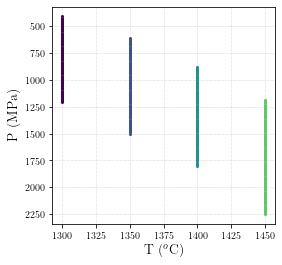

In [8]:
# PT plot
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1,1,1)
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.t, sim0.p, 'o', markersize=markersize, color=colors[0], label=r'1300$^o$C MM3')
plt.plot(sim1.t, sim1.p, 'o', markersize=markersize, color=colors[1], label=r'1350$^o$C MM3')
plt.plot(sim2.t, sim2.p, 'o', markersize=markersize, color=colors[2], label=r'1400$^o$C MM3')
plt.plot(sim3.t, sim3.p, 'o', markersize=markersize, color=colors[3], label=r'1450$^o$C MM3')
plt.xlabel(r'T ($^o$C)', fontsize=fontsize)
plt.ylabel(r'P (MPa)', fontsize=fontsize)
plt.gca().invert_yaxis()
# plt.legend(fontsize='small')
plt.show()

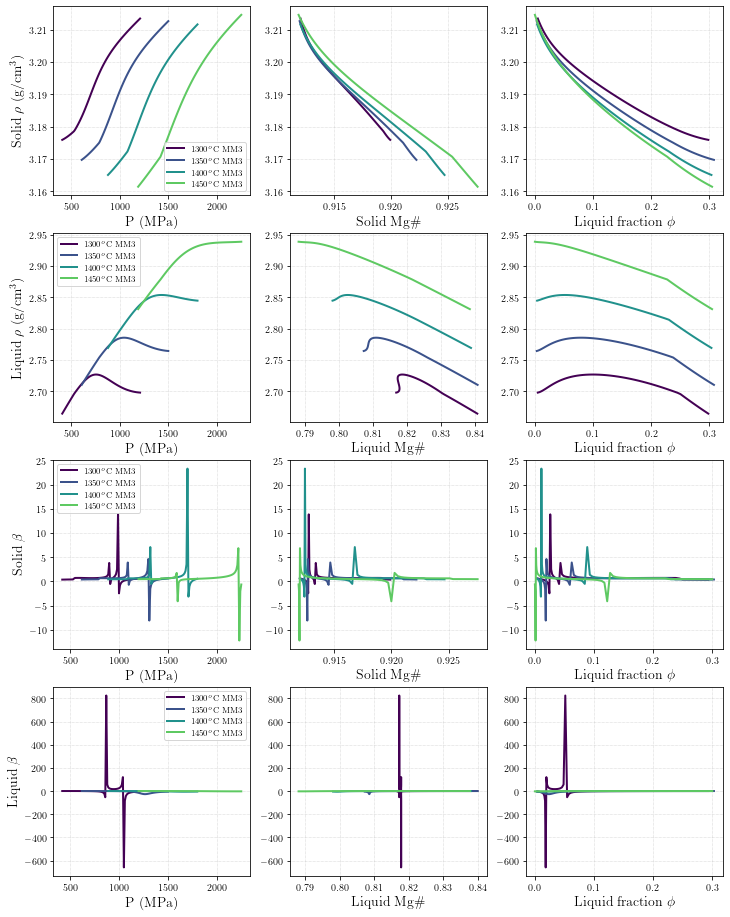

In [9]:
# density vs T, Mg#, phi 

ind_sim0  = np.where(sim0.phi>0.0)
ind_sim1  = np.where(sim1.phi>0.0)
ind_sim2  = np.where(sim2.phi>0.0)
ind_sim3  = np.where(sim3.phi>0.0)

# Figure 2
fig = plt.figure(figsize=(12,16))
ax = plt.subplot(4,3,1)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.p, sim0.rhos, linestyle='-', linewidth=linewidth, color=colors[0], label=r'1300$^o$C MM3')
plt.plot(sim1.p, sim1.rhos, linestyle='-', linewidth=linewidth, color=colors[1], label=r'1350$^o$C MM3')
plt.plot(sim2.p, sim2.rhos, linestyle='-', linewidth=linewidth, color=colors[2], label=r'1400$^o$C MM3')
plt.plot(sim3.p, sim3.rhos, linestyle='-', linewidth=linewidth, color=colors[3], label=r'1450$^o$C MM3')
plt.xlabel(r'P (MPa)', fontsize=fontsize)
plt.ylabel(r'Solid $\rho$ (g/cm$^3$)', fontsize=fontsize)
plt.legend(fontsize='small')

ax = plt.subplot(4,3,2)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.Mgs, sim0.rhos, linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.Mgs, sim1.rhos, linestyle='-', linewidth=linewidth, color=colors[1])
plt.plot(sim2.Mgs, sim2.rhos, linestyle='-', linewidth=linewidth, color=colors[2])
plt.plot(sim3.Mgs, sim3.rhos, linestyle='-', linewidth=linewidth, color=colors[3])
plt.xlabel(r'Solid Mg\#', fontsize=fontsize)

ax = plt.subplot(4,3,3)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.phi, sim0.rhos, linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.phi, sim1.rhos, linestyle='-', linewidth=linewidth, color=colors[1])
plt.plot(sim2.phi, sim2.rhos, linestyle='-', linewidth=linewidth, color=colors[2])
plt.plot(sim3.phi, sim3.rhos, linestyle='-', linewidth=linewidth, color=colors[3])
plt.xlabel(r'Liquid fraction $\phi$', fontsize=fontsize)

ax = plt.subplot(4,3,4)
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.p[ind_sim0[0]], sim0.rhof[ind_sim0[0]], linestyle='-', linewidth=linewidth, color=colors[0], label=r'1300$^o$C MM3')
plt.plot(sim1.p[ind_sim1[0]], sim1.rhof[ind_sim1[0]], linestyle='-', linewidth=linewidth, color=colors[1], label=r'1350$^o$C MM3')
plt.plot(sim2.p[ind_sim2[0]], sim2.rhof[ind_sim2[0]], linestyle='-', linewidth=linewidth, color=colors[2], label=r'1400$^o$C MM3')
plt.plot(sim3.p[ind_sim3[0]], sim3.rhof[ind_sim3[0]], linestyle='-', linewidth=linewidth, color=colors[3], label=r'1450$^o$C MM3')
plt.xlabel(r'P (MPa)', fontsize=fontsize)
plt.ylabel(r'Liquid $\rho$ (g/cm$^3$)', fontsize=fontsize)
plt.legend(fontsize='small')

ax = plt.subplot(4,3,5)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.Mgf[ind_sim0[0]], sim0.rhof[ind_sim0[0]], linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.Mgf[ind_sim1[0]], sim1.rhof[ind_sim1[0]], linestyle='-', linewidth=linewidth, color=colors[1])
plt.plot(sim2.Mgf[ind_sim2[0]], sim2.rhof[ind_sim2[0]], linestyle='-', linewidth=linewidth, color=colors[2])
plt.plot(sim3.Mgf[ind_sim3[0]], sim3.rhof[ind_sim3[0]], linestyle='-', linewidth=linewidth, color=colors[3])
plt.xlabel(r'Liquid Mg\#', fontsize=fontsize)

ax = plt.subplot(4,3,6)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.phi[ind_sim0[0]], sim0.rhof[ind_sim0[0]], linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.phi[ind_sim1[0]], sim1.rhof[ind_sim1[0]], linestyle='-', linewidth=linewidth, color=colors[1])
plt.plot(sim2.phi[ind_sim2[0]], sim2.rhof[ind_sim2[0]], linestyle='-', linewidth=linewidth, color=colors[2])
plt.plot(sim3.phi[ind_sim3[0]], sim3.rhof[ind_sim3[0]], linestyle='-', linewidth=linewidth, color=colors[3])
plt.xlabel(r'Liquid fraction $\phi$', fontsize=fontsize)

ax = plt.subplot(4,3,7)
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.p[:-1], sim0.betas, linestyle='-', linewidth=linewidth, color=colors[0], label=r'1300$^o$C MM3')
plt.plot(sim1.p[:-1], sim1.betas, linestyle='-', linewidth=linewidth, color=colors[1], label=r'1350$^o$C MM3')
plt.plot(sim2.p[:-1], sim2.betas, linestyle='-', linewidth=linewidth, color=colors[2], label=r'1400$^o$C MM3')
plt.plot(sim3.p[:-1], sim3.betas, linestyle='-', linewidth=linewidth, color=colors[3], label=r'1450$^o$C MM3')
plt.xlabel(r'P (MPa)', fontsize=fontsize)
plt.ylabel(r'Solid $\beta$', fontsize=fontsize)
plt.legend(fontsize='small')

ax = plt.subplot(4,3,8)
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.Mgs[:-1], sim0.betas, linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.Mgs[:-1], sim1.betas, linestyle='-', linewidth=linewidth, color=colors[1])
plt.plot(sim2.Mgs[:-1], sim2.betas, linestyle='-', linewidth=linewidth, color=colors[2])
plt.plot(sim3.Mgs[:-1], sim3.betas, linestyle='-', linewidth=linewidth, color=colors[3])
plt.xlabel(r'Solid Mg\#', fontsize=fontsize)

ax = plt.subplot(4,3,9)
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.phi[:-1], sim0.betas, linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.phi[:-1], sim1.betas, linestyle='-', linewidth=linewidth, color=colors[1])
plt.plot(sim2.phi[:-1], sim2.betas, linestyle='-', linewidth=linewidth, color=colors[2])
plt.plot(sim3.phi[:-1], sim3.betas, linestyle='-', linewidth=linewidth, color=colors[3])
plt.xlabel(r'Liquid fraction $\phi$', fontsize=fontsize)

ax = plt.subplot(4,3,10)
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.p[ind_sim0[0][:-1]], sim0.betaf[ind_sim0[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[0], label=r'1300$^o$C MM3')
plt.plot(sim1.p[ind_sim1[0][:-1]], sim1.betaf[ind_sim1[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[1], label=r'1350$^o$C MM3')
plt.plot(sim2.p[ind_sim2[0][:-1]], sim2.betaf[ind_sim2[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[2], label=r'1400$^o$C MM3')
plt.plot(sim3.p[ind_sim3[0][:-1]], sim3.betaf[ind_sim3[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[3], label=r'1450$^o$C MM3')
plt.xlabel(r'P (MPa)', fontsize=fontsize)
plt.ylabel(r'Liquid $\beta$', fontsize=fontsize)
plt.legend(fontsize='small')

ax = plt.subplot(4,3,11)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.Mgf[ind_sim0[0][:-1]], sim0.betaf[ind_sim0[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.Mgf[ind_sim1[0][:-1]], sim1.betaf[ind_sim1[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[1])
plt.plot(sim2.Mgf[ind_sim2[0][:-1]], sim2.betaf[ind_sim2[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[2])
plt.plot(sim3.Mgf[ind_sim3[0][:-1]], sim3.betaf[ind_sim3[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[3])
plt.xlabel(r'Liquid Mg\#', fontsize=fontsize)

ax = plt.subplot(4,3,12)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.phi[ind_sim0[0][:-1]], sim0.betaf[ind_sim0[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.phi[ind_sim1[0][:-1]], sim1.betaf[ind_sim1[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[1])
plt.plot(sim2.phi[ind_sim2[0][:-1]], sim2.betaf[ind_sim2[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[2])
plt.plot(sim3.phi[ind_sim3[0][:-1]], sim3.betaf[ind_sim3[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[3])
plt.xlabel(r'Liquid fraction $\phi$', fontsize=fontsize)

# plt.savefig('density_change_isothermal_v2.pdf')
plt.show()

In [10]:
# Average betaT
print('Average betaT (liquid,solid):')
print('1300C   : ',np.average(sim0.betaf[ind_sim0[0][:-1]]),np.average(sim0.betas[ind_sim0[0][:-1]]))
print('1350C    : ',np.average(sim1.betaf[ind_sim1[0][:-1]]),np.average(sim1.betas[ind_sim1[0][:-1]]))
print('1400C    : ',np.average(sim2.betaf[ind_sim2[0][:-1]]),np.average(sim2.betas[ind_sim2[0][:-1]]))
print('1450C    : ',np.average(sim3.betaf[ind_sim3[0][:-1]]),np.average(sim3.betas[ind_sim3[0][:-1]]))

Average betaT (liquid,solid):
1300C   :  4.12624204982002 0.7445985288994821
1350C    :  -5.870403726480869 0.5224718716370431
1400C    :  -1.55372751049049 0.8844073075554677
1450C    :  -0.4704074940181719 0.5570212485315427


### 3. Isentropic conditions (adiabatic, S=ct)

In [11]:
def run_isentropic_melting(bulk_comp,Tstart,Pstart,Pfinal):
    sim=EmptyStruct()
    sim.bulk_comp = bulk_comp

    # create new pMELTS object with a given bulk composition
    melts, Phases_all = create_pmelts_object(sim.bulk_comp)
    output = melts.equilibrate_tp(Tstart, Pstart, initialize=True)
    (status, t, p, xmlout) = output[0]

    # compute entropy S (J/K) at specified P (MPa)
    Sstart = melts.get_property_of_phase(xmlout,'System', 'Entropy')

    # run the sequence of calculations along a S=constant, P path
    # nsteps = 200
    s_increment = 0.0
    p_increment = -10.0
    nsteps = int((Pfinal-Pstart)/p_increment)

    sim.p   = np.zeros(nsteps)
    sim.s   = np.zeros(nsteps)
    sim.t   = np.zeros(nsteps)
    sim.phi = np.zeros(nsteps)
    sim.rhof= np.zeros(nsteps)
    sim.rhos= np.zeros(nsteps)
    sim.Mgf = np.zeros(nsteps)
    sim.Mgs = np.zeros(nsteps)
    sim.alphaf= np.zeros(nsteps)
    sim.alphas= np.zeros(nsteps)
    sim.kf    = np.zeros(nsteps)
    sim.ks    = np.zeros(nsteps)
    sim.betaf = np.zeros(nsteps-1)
    sim.betas = np.zeros(nsteps-1)
    sim.phases= Phases_all
    
    sol = [EmptyStruct() for i in range(nsteps)]
    sim.sol = sol

    sim.p[0] = Pstart
    sim.t[0] = Tstart
    sim.s[0] = Sstart

    for i in range (1,nsteps):
        sim.p[i] = sim.p[i-1]+p_increment
        sim.s[i] = sim.s[i-1]+s_increment

    for i in range (0,nsteps):
        if (i==0):
            output = melts.equilibrate_sp(sim.s[i],sim.p[i], initialize=True)
        else:
            output = melts.equilibrate_sp(sim.s[i],sim.p[i])
        (status, t, p, xmlout) = output[0]
        sim.t[i] = t
        
        # get properties
        sim.sol[i]   = EmptyStruct()
        sim.phi[i], sim.rhof[i], sim.Mgf[i], sim.alphaf[i], sim.kf[i], sim.sol[i] = get_density_Mg_liquid_solid(melts,xmlout,sim.t[i],sim.p[i],Phases_all)
        
        # bulk solid phase
        sim.rhos[i]   = get_bulk_density(sim.sol[i].n,sim.sol[i].x,sim.sol[i].rho)
        sim.alphas[i] = get_bulk_property(sim.sol[i].n,sim.sol[i].x,sim.sol[i].alpha)
        sim.ks[i]     = get_bulk_property(sim.sol[i].n,sim.sol[i].x,sim.sol[i].k)
        sim.Mgs[i]    = get_bulk_property(sim.sol[i].n,sim.sol[i].x,sim.sol[i].Mg)

        if (i>0):
            DP  = sim.p[i]-sim.p[i-1] # MPa
            DT  = sim.t[i]-sim.t[i-1]
            DCF = sim.Mgf[i]-sim.Mgf[i-1]
            sim.betaf[i-1] = calculate_betaS(sim.rhof[i-1],sim.rhof[i],sim.kf[i],sim.alphaf[i],DP,DT,DCF)
            
            # mineral phase
            for im in range (0, sim.sol[i].n):
                if (sim.sol[i].x[im]>0.0):
                    rho0 = sim.sol[i-1].rho[im]
                    rho  = sim.sol[i].rho[im]
                    k    = sim.sol[i].k[im]
                    alpha= sim.sol[i].alpha[im]
                    DCS  = sim.sol[i].Mg[im]-sim.sol[i-1].Mg[im]
                    sim.sol[i].beta[im] = calculate_betaS(rho0,rho,k,alpha,DP,DT,DCS)
            sim.betas[i-1] = get_bulk_property(sim.sol[i].n,sim.sol[i].x,sim.sol[i].beta)
    return sim

# isentropic simulations
del sim0, sim1, sim2, sim3
# del sim0, sim1
sim0 = run_isentropic_melting('MM3',1420,2000,400) # Tstart, Pstart, Pfinal; phi [0.00109972 - 0.29168933]
sim1 = run_isentropic_melting('mBas',1380,2000,300) # Tstart, Pstart, Pfinal; phi [0.00150459 - 0.28108829]

# save pickle data
fname_pickle = 'sim_3_isentropic_v2.pickle'
with open(fname_pickle, 'wb') as fh:
    pickle.dump(sim0,fh)
    pickle.dump(sim1,fh)

# print(sim0.phi)

## Plots

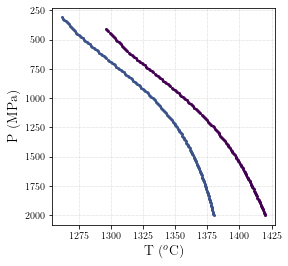

In [12]:
# PT plot
fig = plt.figure(figsize=(4,4))
ax = plt.subplot(1,1,1)
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.t, sim0.p, 'o', markersize=markersize, color=colors[0], label=r'MM3')
plt.plot(sim1.t, sim1.p, 'o', markersize=markersize, color=colors[1], label=r'mBas')
plt.xlabel(r'T ($^o$C)', fontsize=fontsize)
plt.ylabel(r'P (MPa)', fontsize=fontsize)
plt.gca().invert_yaxis()
# plt.legend(fontsize='small')
plt.show()

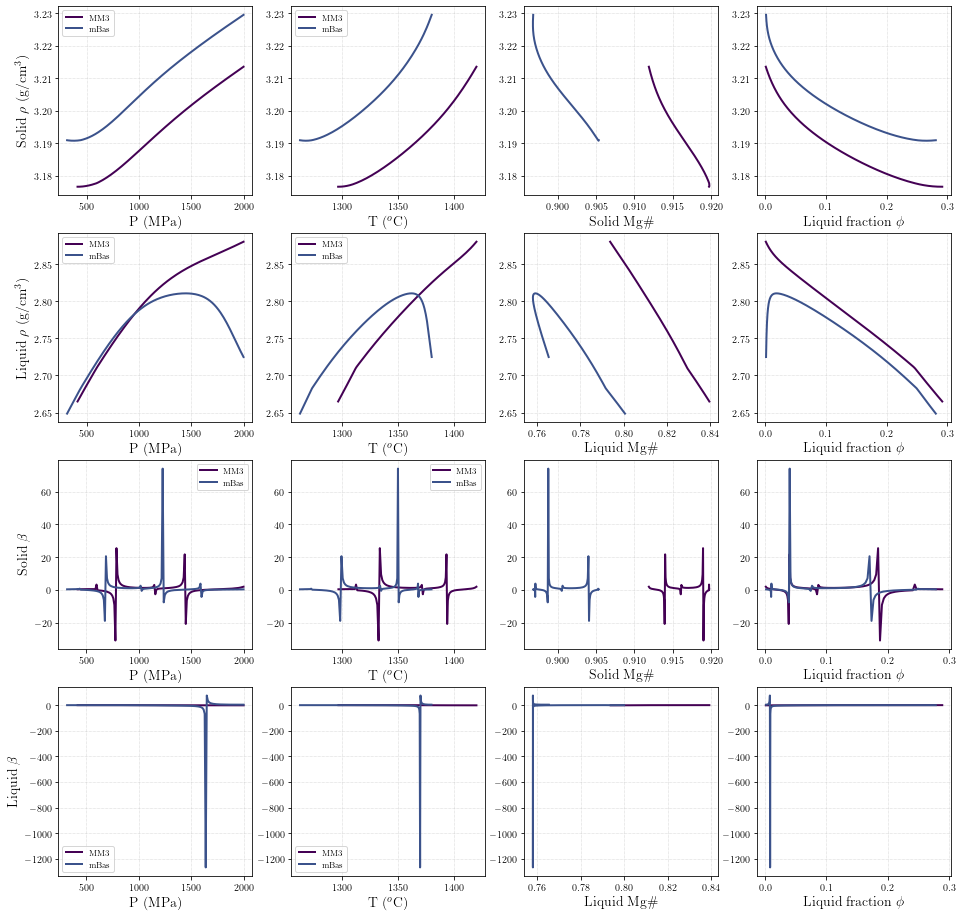

In [13]:
# density vs T, Mg#, phi 
ind_sim0  = np.where(sim0.phi>0.0)
ind_sim1  = np.where(sim1.phi>0.0)

# Figure 3
fig = plt.figure(figsize=(16,16))
ax = plt.subplot(4,4,1)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.p, sim0.rhos, linestyle='-', linewidth=linewidth, color=colors[0], label=r'MM3')
plt.plot(sim1.p, sim1.rhos, linestyle='-', linewidth=linewidth, color=colors[1], label=r'mBas')
plt.xlabel(r'P (MPa)', fontsize=fontsize)
plt.ylabel(r'Solid $\rho$ (g/cm$^3$)', fontsize=fontsize)
plt.legend(fontsize='small')

ax = plt.subplot(4,4,2)
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.t, sim0.rhos, linestyle='-', linewidth=linewidth, color=colors[0], label='MM3')
plt.plot(sim1.t, sim1.rhos, linestyle='-', linewidth=linewidth, color=colors[1], label='mBas')
plt.xlabel(r'T ($^o$C)', fontsize=fontsize)
plt.legend(fontsize='small')

ax = plt.subplot(4,4,3)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.Mgs, sim0.rhos, linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.Mgs, sim1.rhos, linestyle='-', linewidth=linewidth, color=colors[1])
plt.xlabel(r'Solid Mg\#', fontsize=fontsize)

ax = plt.subplot(4,4,4)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.phi, sim0.rhos, linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.phi, sim1.rhos, linestyle='-', linewidth=linewidth, color=colors[1])
plt.xlabel(r'Liquid fraction $\phi$', fontsize=fontsize)

ax = plt.subplot(4,4,5)
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.p[ind_sim0[0]], sim0.rhof[ind_sim0[0]], linestyle='-', linewidth=linewidth, color=colors[0], label=r'MM3')
plt.plot(sim1.p[ind_sim1[0]], sim1.rhof[ind_sim1[0]], linestyle='-', linewidth=linewidth, color=colors[1], label=r'mBas')
plt.xlabel(r'P (MPa)', fontsize=fontsize)
plt.ylabel(r'Liquid $\rho$ (g/cm$^3$)', fontsize=fontsize)
plt.legend(fontsize='small')

ax = plt.subplot(4,4,6)
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.t, sim0.rhof, linestyle='-', linewidth=linewidth, color=colors[0], label='MM3')
plt.plot(sim1.t, sim1.rhof, linestyle='-', linewidth=linewidth, color=colors[1], label='mBas')
plt.xlabel(r'T ($^o$C)', fontsize=fontsize)
plt.legend(fontsize='small')

ax = plt.subplot(4,4,7)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.Mgf[ind_sim0[0]], sim0.rhof[ind_sim0[0]], linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.Mgf[ind_sim1[0]], sim1.rhof[ind_sim1[0]], linestyle='-', linewidth=linewidth, color=colors[1])
plt.xlabel(r'Liquid Mg\#', fontsize=fontsize)

ax = plt.subplot(4,4,8)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.phi[ind_sim0[0]], sim0.rhof[ind_sim0[0]], linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.phi[ind_sim1[0]], sim1.rhof[ind_sim1[0]], linestyle='-', linewidth=linewidth, color=colors[1])
plt.xlabel(r'Liquid fraction $\phi$', fontsize=fontsize)

ax = plt.subplot(4,4,9)
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.p[:-1], sim0.betas, linestyle='-', linewidth=linewidth, color=colors[0], label=r'MM3')
plt.plot(sim1.p[:-1], sim1.betas, linestyle='-', linewidth=linewidth, color=colors[1], label=r'mBas')
plt.xlabel(r'P (MPa)', fontsize=fontsize)
plt.ylabel(r'Solid $\beta$', fontsize=fontsize)
plt.legend(fontsize='small')

ax = plt.subplot(4,4,10)
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.t[:-1], sim0.betas, linestyle='-', linewidth=linewidth, color=colors[0], label='MM3')
plt.plot(sim1.t[:-1], sim1.betas, linestyle='-', linewidth=linewidth, color=colors[1], label='mBas')
plt.xlabel(r'T ($^o$C)', fontsize=fontsize)
plt.legend(fontsize='small')

ax = plt.subplot(4,4,11)
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.Mgs[:-1], sim0.betas, linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.Mgs[:-1], sim1.betas, linestyle='-', linewidth=linewidth, color=colors[1])
plt.xlabel(r'Solid Mg\#', fontsize=fontsize)

ax = plt.subplot(4,4,12)
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.phi[:-1], sim0.betas, linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.phi[:-1], sim1.betas, linestyle='-', linewidth=linewidth, color=colors[1])
plt.xlabel(r'Liquid fraction $\phi$', fontsize=fontsize)

ax = plt.subplot(4,4,13)
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.p[ind_sim0[0][:-1]], sim0.betaf[ind_sim0[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[0], label=r'MM3')
plt.plot(sim1.p[ind_sim1[0][:-1]], sim1.betaf[ind_sim1[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[1], label=r'mBas')
plt.xlabel(r'P (MPa)', fontsize=fontsize)
plt.ylabel(r'Liquid $\beta$', fontsize=fontsize)
plt.legend(fontsize='small')

ax = plt.subplot(4,4,14)
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.t[ind_sim0[0][:-1]], sim0.betaf[ind_sim0[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[0], label='MM3')
plt.plot(sim1.t[ind_sim1[0][:-1]], sim1.betaf[ind_sim1[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[1], label='mBas')
plt.xlabel(r'T ($^o$C)', fontsize=fontsize)
plt.legend(fontsize='small')

ax = plt.subplot(4,4,15)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.Mgf[ind_sim0[0][:-1]], sim0.betaf[ind_sim0[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.Mgf[ind_sim1[0][:-1]], sim1.betaf[ind_sim1[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[1])
plt.xlabel(r'Liquid Mg\#', fontsize=fontsize)

ax = plt.subplot(4,4,16)
# ax = plt.axes()
plt.grid(linestyle=':', linewidth=0.5)
plt.plot(sim0.phi[ind_sim0[0][:-1]], sim0.betaf[ind_sim0[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[0])
plt.plot(sim1.phi[ind_sim1[0][:-1]], sim1.betaf[ind_sim1[0][:-1]], linestyle='-', linewidth=linewidth, color=colors[1])
plt.xlabel(r'Liquid fraction $\phi$', fontsize=fontsize)

# plt.savefig('density_change_isentropic_v2.pdf')
plt.show()

In [14]:
# Average betaS
print('Average betaS (liquid,solid):')
print('MM3   : ',np.average(sim0.betaf[ind_sim0[0][:-1]]),np.average(sim0.betas[ind_sim0[0][:-1]]))
print('mBas  : ',np.average(sim1.betaf[ind_sim1[0][:-1]]),np.average(sim1.betas[ind_sim1[0][:-1]]))

Average betaS (liquid,solid):
MM3   :  0.2583384592574306 0.6489704550104486
mBas  :  -6.7550230791384775 0.8816884572143381
